# Brain Tumor Classification

In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
# Import data managing libraries
import numpy as np
import pandas as pd

# Import Tensorflow
import tensorflow as tf
import tensorflow.keras as keras

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import random
# Set the seed for repeatability
seed = 42

# Set random seed for NumPy
np.random.seed(42)

# Set random seed for TensorFlow
tf.random.set_seed(42)

# Set random seed for Python's built-in random module
random.seed(42)

In [3]:
from functions import process_data
import os

# Define data folder
data_folder = "data/"

# Define train, val, test folders
train_folder = os.path.join(data_folder, "Training/")
test_folder = os.path.join(data_folder, "Testing/")
val_folder = os.path.join(data_folder, "Validation/")

# Define our data directories
train_data_dir = train_folder
test_data_dir = test_folder
val_data_dir = val_folder

train_gen, test_gen, val_gen = process_data(256, 32, train_data_dir, test_data_dir, val_data_dir)

Found 2297 images belonging to 4 classes.
Found 394 images belonging to 4 classes.
Found 573 images belonging to 4 classes.


In [4]:
# Find out how the image data generators labeled our classes
train_class_labels = train_gen.class_indices
val_class_labels = train_gen.class_indices
test_class_labels = val_gen.class_indices

# Print the class labels
print("Train Class Labels:", train_class_labels)
print("Validation Class Labels:", val_class_labels)
print("Test Class Labels:", test_class_labels)

Train Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Validation Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
Test Class Labels: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


In [5]:
# Retrieve one batch of data from the generator
data_batch, label_batch = next(train_gen)

# Print the shape of the data batch and label batch
print("Data batch shape:", data_batch.shape)
print("Label batch shape:", label_batch.shape)

Data batch shape: (32, 256, 256, 3)
Label batch shape: (32, 4)


Image dimensions: (256, 256, 3)


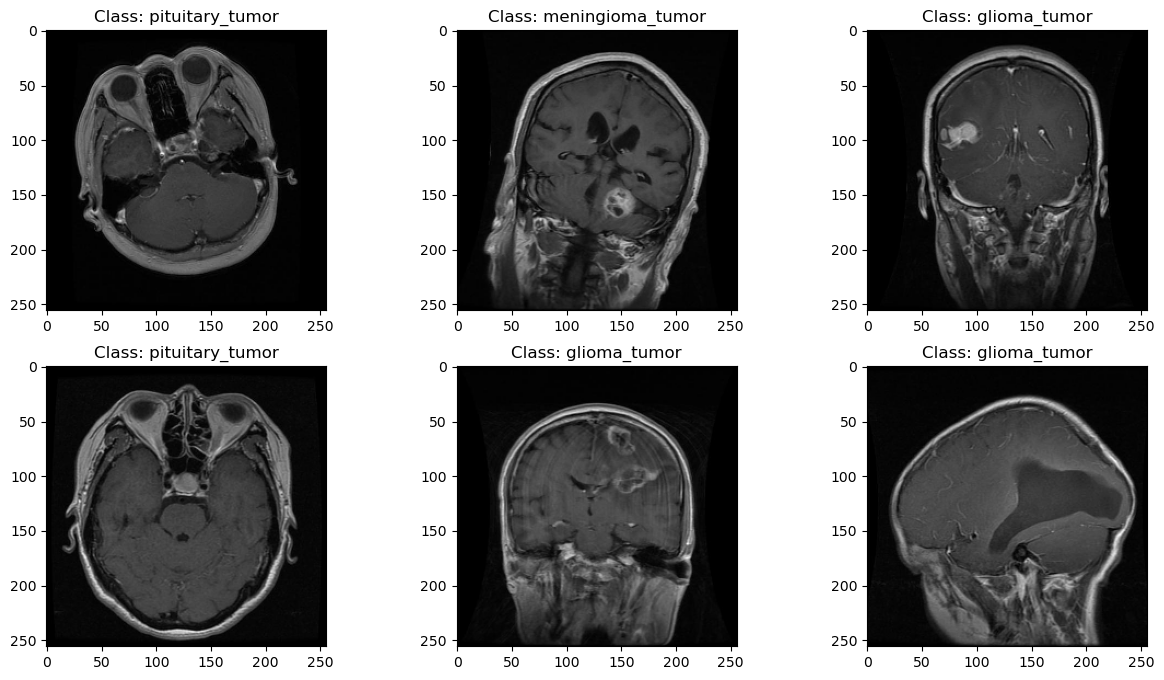

In [6]:
import matplotlib.pyplot as plt

# Retrieve one batch of images from the generator
images, labels = train_gen.next()

# Print the dimensions of the first image
print("Image dimensions:", images[0].shape)

# Define the class labels
class_labels = {'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}

# Display the first six images with their labels
fig, ax = plt.subplots(2, 3, facecolor='white', figsize=(15, 8))

for i in range(2):
    for j in range(3):
        # Calculate the index in the images and labels arrays
        idx = i * 3 + j
        
        # Get the predicted class
        class_idx = np.argmax(labels[idx])
        
        # Get the class name from the label
        class_name = [key for key, value in class_labels.items() if value == class_idx][0]
        
        # Plot the image
        ax[i, j].imshow(images[idx])
        ax[i, j].set_title(f"Class: {class_name}")

plt.show()

We want to implement cross-validation into the training process. There are no built in methods within keras that can allow for this to happen but there are methods in scikit-learn. We can take the generators that pre-priocess the data and append the images to a dataframe. From there we can then split the data using KFold. 

In [7]:
# # Extract data and labels from the generated batches on train set
# data_train, labels_train = [], []
# for _ in range(len(train_gen)):
#     images_train, batch_labels_train = train_gen.next()  # Get the next batch of data
#     data_train.extend(images_train)
#     labels_train.extend(batch_labels_train)

# # Extract data and labels from the generated batches on test set
# data_test, labels_test = [], []
# for _ in range(len(test_gen)):
#     images_test, batch_labels_test = test_gen.next()  # Get the next batch of data
#     data_test.extend(images_train)
#     labels_test.extend(batch_labels_test)

# # Extract data and labels from the generated batches on validation set
# data_val, labels_val = [], []
# for _ in range(len(val_gen)):
#     images_val, batch_labels_val = val_gen.next()  # Get the next batch of data
#     data_val.extend(images_val)
#     labels_val.extend(batch_labels_val)

# # Flatten the image data
# data_train_flat = np.array(data_train).reshape(len(data_train), -1)
# data_test_flat = np.array(data_test).reshape(len(data_test), -1)
# data_val_flat = np.array(data_val).reshape(len(data_val), -1)

# # Create Dataframes for each set. Keep class labels in order
# df_train_data = pd.DataFrame(data_train_flat)
# df_train_labels = pd.DataFrame(labels_train, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_train = pd.concat([df_train_data, df_train_labels], axis=1)

# df_test_data = pd.DataFrame(data_test_flat)
# df_test_labels = pd.DataFrame(labels_test, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_test = pd.concat([df_test_data, df_test_labels], axis=1)

# df_val_data = pd.DataFrame(data_val_flat)
# df_val_labels = pd.DataFrame(labels_val, columns=["glioma_tumor", "meningioma_tumor", "no_tumor", "pituitary_tumor"])
# df_val = pd.concat([df_val_data, df_val_labels], axis=1)

In [8]:
# df_train.head(5)

In [9]:
# # Display the shape of each DataFrame
# print("Train DataFrame shape:", df_train.shape)
# print("Test DataFrame shape:", df_test.shape)
# print("Validation DataFrame shape:", df_val.shape)

Seems that the dataframe worked. We have almost 20,000 columns for image data and the last four columns are our labels. 

# Convolutinal Base

In [10]:
from tensorflow.keras.metrics import Precision, Recall

# Define metrics we want to log for the compile method callback
metrics = [
        Precision(name='precision'),
        Recall(name='recall'),
        'accuracy'
    ]


In [11]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', strides=(2,2), input_shape=input_shape))
cnn.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))

# Define the output 
cnn.add(Dense(4, activation='softmax'))

cnn.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 63504)             0         
                                                                 
 dense (Dense)               (None, 128)               8128640   
                                                                 
 dense_1 (Dense)             (None, 4)                 516       
                                                                 
Total params: 8,129,604
Trainable params: 8,129,604
Non-trainable params: 0
______________________________________________

Epoch 1/30
72/72 [==============================] - 7s 56ms/step - loss: 0.9920 - precision: 0.7007 - recall: 0.4393 - accuracy: 0.6077 - val_loss: 0.5929 - val_precision: 0.8000 - val_recall: 0.7120 - val_accuracy: 0.7696
Epoch 2/30
72/72 [==============================] - 4s 53ms/step - loss: 0.3655 - precision: 0.8876 - recall: 0.8524 - accuracy: 0.8729 - val_loss: 0.4580 - val_precision: 0.8294 - val_recall: 0.8063 - val_accuracy: 0.8202
Epoch 3/30
72/72 [==============================] - 4s 51ms/step - loss: 0.1655 - precision: 0.9564 - recall: 0.9447 - accuracy: 0.9508 - val_loss: 0.4247 - val_precision: 0.8589 - val_recall: 0.8394 - val_accuracy: 0.8517
Epoch 4/30
72/72 [==============================] - 4s 53ms/step - loss: 0.0809 - precision: 0.9826 - recall: 0.9813 - accuracy: 0.9822 - val_loss: 0.3469 - val_precision: 0.8688 - val_recall: 0.8551 - val_accuracy: 0.8639
Epoch 5/30
72/72 [==============================] - 4s 54ms/step - loss: 0.0323 - precision: 0.9978 - recall

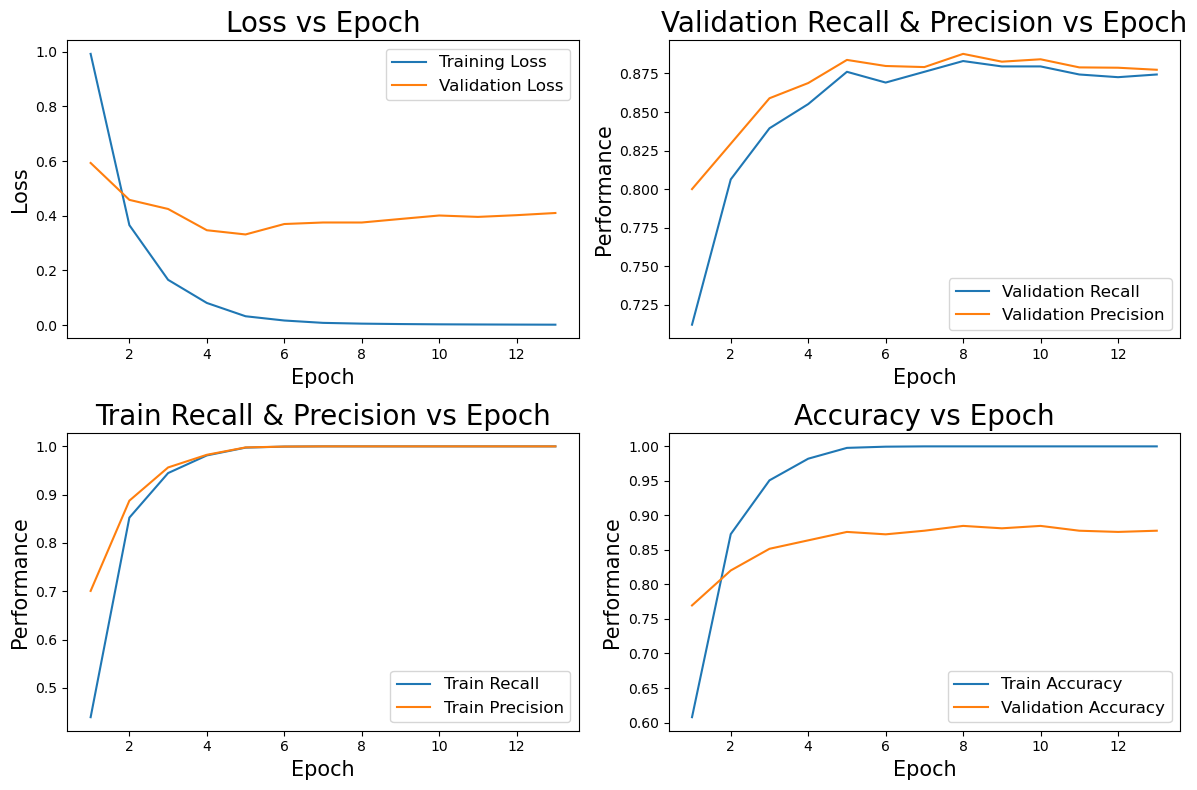

 1/13 [=>............................] - ETA: 0s - loss: 12.3951 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 40ms/step - loss: 0.3315 - precision: 0.8838 - recall: 0.8761 - accuracy: 0.8761


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.015615,100.000000,100.000000,100.000000
1,Test,2.793877,71.538460,70.812184,70.812184
2,Validation,0.331456,88.380283,87.609076,87.609076


In [12]:
from functions import train_model, model_evaluate, view_history

conv = {}

# Train model
conv['Version1'] = train_model(cnn, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version1')

# Evalaute model
model_evaluate(cnn, train_gen, test_gen, val_gen)

It seems that our might be overfitting. We can tell because the val_loss curve does not decrease but rather starts increasing. Lets reduce the complexity of the model to see if it helps.

# CNN Version 2

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn2 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(2,2), input_shape=input_shape))
cnn2.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn2.add(Flatten())
cnn2.add(Dense(128, activation='relu'))

# Define the output 
cnn2.add(Dense(4, activation='softmax'))

cnn2.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 127, 127, 64)      1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 63, 63, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 254016)            0         
                                                                 
 dense_2 (Dense)             (None, 128)               32514176  
                                                                 
 dense_3 (Dense)             (None, 4)                 516       
                                                                 
Total params: 32,516,484
Trainable params: 32,516,484
Non-trainable params: 0
__________________________________________

Epoch 1/30
72/72 [==============================] - 5s 55ms/step - loss: 1.3626 - precision: 0.7405 - recall: 0.4951 - accuracy: 0.5912 - val_loss: 0.6000 - val_precision: 0.7539 - val_recall: 0.6789 - val_accuracy: 0.7208
Epoch 2/30
72/72 [==============================] - 4s 52ms/step - loss: 0.3457 - precision: 0.8926 - recall: 0.8537 - accuracy: 0.8777 - val_loss: 0.4148 - val_precision: 0.8345 - val_recall: 0.8098 - val_accuracy: 0.8168
Epoch 3/30
72/72 [==============================] - 4s 52ms/step - loss: 0.1227 - precision: 0.9680 - recall: 0.9626 - accuracy: 0.9652 - val_loss: 0.4007 - val_precision: 0.8515 - val_recall: 0.8307 - val_accuracy: 0.8377
Epoch 4/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0485 - precision: 0.9921 - recall: 0.9900 - accuracy: 0.9922 - val_loss: 0.3741 - val_precision: 0.8761 - val_recall: 0.8639 - val_accuracy: 0.8691
Epoch 5/30
72/72 [==============================] - 4s 51ms/step - loss: 0.0150 - precision: 0.9996 - recall

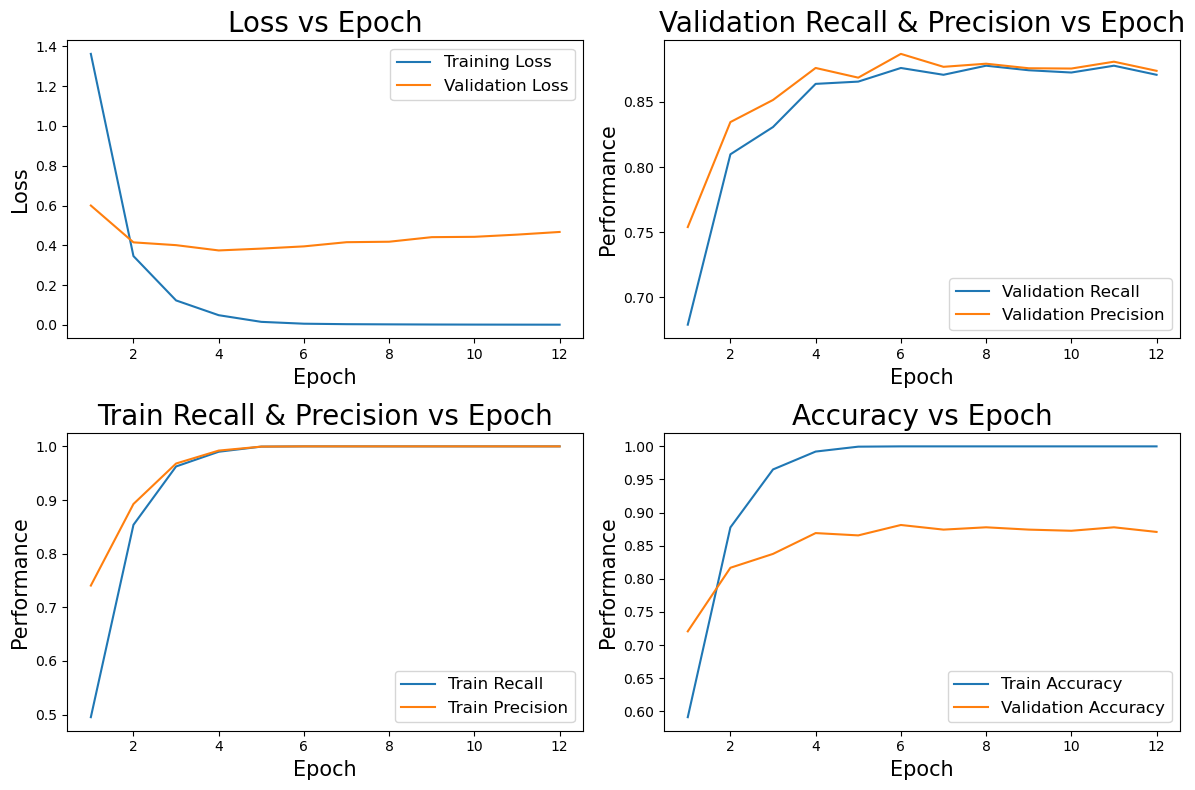

 3/13 [=====>........................] - ETA: 0s - loss: 10.7283 - precision: 0.1915 - recall: 0.1875 - accuracy: 0.1875            

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 40ms/step - loss: 0.3741 - precision: 0.8761 - recall: 0.8639 - accuracy: 0.8691


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.019408,99.956405,99.825859,99.912930
1,Test,3.059708,71.649486,70.558375,71.065992
2,Validation,0.374148,87.610620,86.387432,86.910993


In [14]:
from functions import train_model, model_evaluate, view_history

# Train model
conv['Version2'] = train_model(cnn2, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version2')

# Evalaute model
model_evaluate(cnn2, train_gen, test_gen, val_gen)

Increasing the complexity of the Convolutional layer caused us to overfit. Lets regularize the model.

# CNN versionn 3

In [15]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn3 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn3.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', strides=(2,2), input_shape=input_shape))
cnn3.add(Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), activation='relu'))
cnn3.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn3.add(Flatten())
cnn3.add(Dense(256, activation='relu'))
cnn3.add(Dense(256, activation='relu'))

# Define the output 
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 127, 127, 64)      1792      
                                                                 
 conv2d_3 (Conv2D)           (None, 125, 125, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 123008)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               31490304  
                                                                 
 dense_5 (Dense)             (None, 256)               65792     
                                                      

Epoch 1/30
72/72 [==============================] - 5s 60ms/step - loss: 1.2023 - precision: 0.7369 - recall: 0.4498 - accuracy: 0.5603 - val_loss: 0.6316 - val_precision: 0.7660 - val_recall: 0.6911 - val_accuracy: 0.7417
Epoch 2/30
72/72 [==============================] - 4s 53ms/step - loss: 0.4820 - precision: 0.8331 - recall: 0.7780 - accuracy: 0.8080 - val_loss: 0.4173 - val_precision: 0.8582 - val_recall: 0.8133 - val_accuracy: 0.8325
Epoch 3/30
72/72 [==============================] - 4s 53ms/step - loss: 0.1767 - precision: 0.9394 - recall: 0.9308 - accuracy: 0.9351 - val_loss: 0.3852 - val_precision: 0.8637 - val_recall: 0.8517 - val_accuracy: 0.8621
Epoch 4/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0789 - precision: 0.9717 - recall: 0.9704 - accuracy: 0.9708 - val_loss: 0.3875 - val_precision: 0.8785 - val_recall: 0.8709 - val_accuracy: 0.8743
Epoch 5/30
72/72 [==============================] - 4s 52ms/step - loss: 0.0304 - precision: 0.9904 - recall

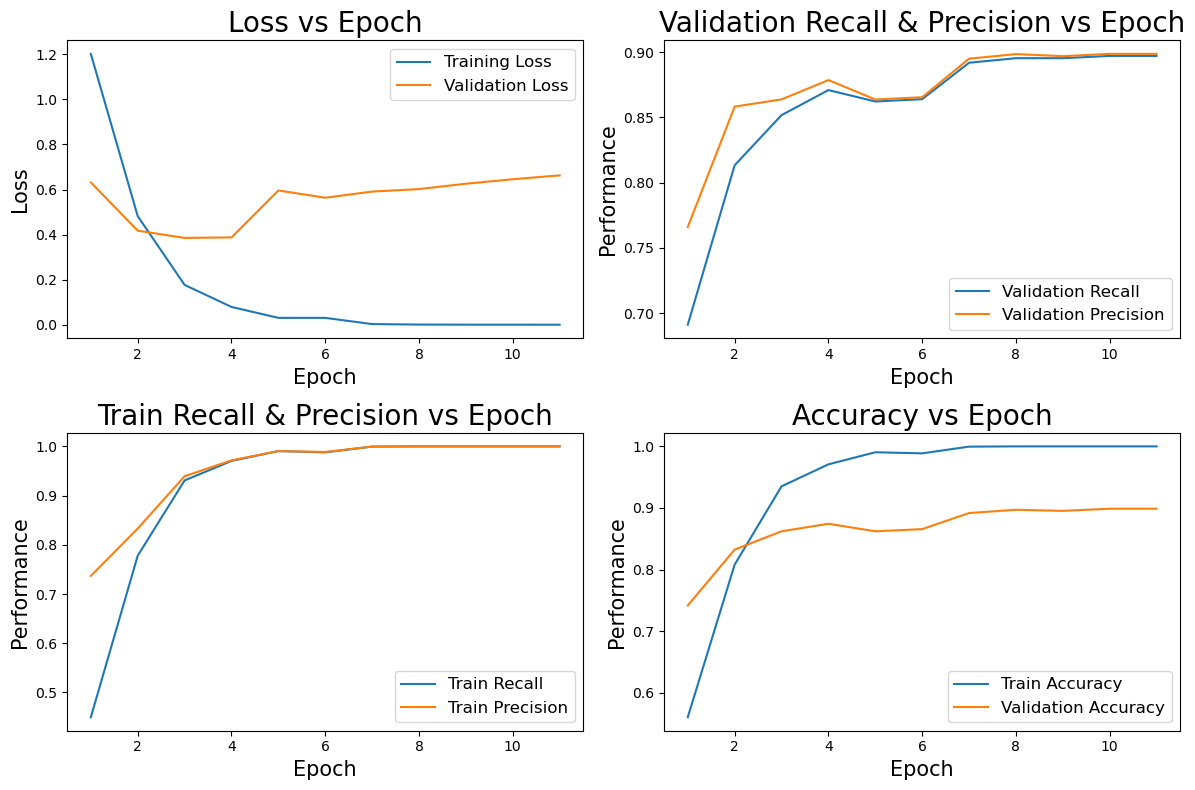

 1/13 [=>............................] - ETA: 1s - loss: 10.6700 - precision: 0.0000e+00 - recall: 0.0000e+00 - accuracy: 0.0000e+00

c:\Users\delga\Documents\Phase5\brain_tumor_classification\functions.py:312: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([dict(zip(columns, train_metrics))])], ignore_index=True)


18/18 [==============================] - 1s 41ms/step - loss: 0.3852 - precision: 0.8637 - recall: 0.8517 - accuracy: 0.8621


,Set,Loss,Precision,Recall,Accuracy
0,Train,0.076415,97.815639,97.474968,97.649109
1,Test,2.445201,65.885419,64.213198,64.974618
2,Validation,0.385201,86.371684,85.165793,86.212915


In [16]:
# Train model
conv['Version3'] = train_model(cnn3, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version3')

# Evalaute model
model_evaluate(cnn3, train_gen, test_gen, val_gen)

It seems that we were actually overfitting. We know for sure now since our validation loss curve went straight up. Lets reduce model complexity.

# CNN Version 4

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn4 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn4.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn4.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn4.add(Flatten())
cnn4.add(Dense(32, activation='relu'))

# Define the output 
cnn4.add(Dense(4, activation='softmax'))

cnn4.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn4.summary())

In [ ]:
# Train model
conv['Version4'] = train_model(cnn4, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version4')

# Evalaute model
model_evaluate(cnn4, train_gen, test_gen, val_gen)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

# Define input shape
input_shape = (256, 256, 3)

# Define the basic model 
cnn5 = Sequential()

# Define the layers 
# Flatten layer to reshape the output
cnn5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))

cnn5.add(Conv2D(filters=16, kernel_size=(5,5), activation='relu', input_shape=input_shape))
cnn5.add(MaxPool2D(pool_size=(2,2)))

# Flatten Tensor
cnn5.add(Flatten())
cnn5.add(Dense(256, activation='relu'))

# Define the output 
cnn5.add(Dense(4, activation='softmax'))

cnn5.compile(optimizer=Adam(), loss=CategoricalCrossentropy(), metrics=metrics)
print(cnn5.summary())

In [ ]:
# Train model
conv['Version5'] = train_model(cnn5, train_gen, val_gen, 30)

# View history 
view_history(conv, 'Version5')

# Evalaute model
model_evaluate(cnn5, train_gen, test_gen, val_gen)